# Предсказание банковских транзакций

**Описание задачи**<br/>
Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях.</br>
В этом соревновании участникам предлагается предсказать будущие траты клиента, используя информацию о совершенных тратах.</br>

**Полезная информация**</br>
Для понимания представленных данных будет полезна следующая <a href="https://www.banki.ru/wikibank/mcc-kod/">*статья*</a></br>

<a href="https://mcc-codes.ru/code">Описание MCC-кодов.</a></br>

**BaseLine**</br>
Для быстрого старта можно использовать решение, приведенное ниже:</br>
https://www.kaggle.com/prampampam/baseline-popular-transactions

**Формат решения задачи**</br>
Решение ожидаем в виде файла csv. Пример: submission_file.csv из <a href="https://www.kaggle.com/competitions/alfabank-campus/data">раздела Data.</a></br>

**Вопросы**</br>
https://www.kaggle.com/competitions/alfabank-campus/discussion/442418

**Метрика качества**</br>
<a href="https://habr.com/ru/companies/econtenta/articles/303458">**MAP@10**</a></br>

**Описание набора данных**




**File descriptions**</br>
1. df_train.csv — данные для обучения предиктиного алгоритма
2. df_test.csv — тестовый датасет
3. submission_file.csv — пример файла сабмита клиента

**Data fields** </br>
1. df_train.csv
   - data - история трат клиентов (последовательность mcc-кодов в хронологическом порядке);
   - target - последовательность будущих трат клиента.
3. df_test.csv
   - Id - идентификатор клиента;
   - история трат клиентов (последовательность mcc-кодов в хронологическом порядке). 
5. submission_file.scv
   - Id - идентификатор клиента;
   - Predicted - предсказание следующих 10 транзакций клиента.

## Получение данных

Общая концепция: 
1. Избавиться от выбросов
2. Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.
3. Обучить модель на данных
4. Предсказать значения для нескольких случаев(10)

Произведём загрузку данных, библиотек и их компонентов

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display 
import matplotlib.pyplot as plt

from termcolor import colored

Определим функцию для загрузки файла

In [2]:
def download_file(name, sep=';'):
    try:
        data = pd.read_csv('data/' + name, index_col ='Id', sep=sep)
        return data
    except Exception as _:
        print('Загрузка файла вызвала ошибку\n', _)

Получим наборы данных для изучения

In [3]:
df_train = download_file('df_train.csv')
df_test = download_file('df_test.csv')
submission_baseline_2 = download_file('submission_baseline_2.csv', sep=',')

**Заключение**\
Данные загружены, однако не ясно, что они из себя представляют. Посмотрим на это.

### Исследование структуры данных

#### df_train

In [4]:
df_train.head(2)

,Data,Target
Id,,
0,"4814,4814,6010,6011,4814,6011,6011,4814,6011,6...","4814,4814,4814,4814,5411,4814,4814,4814,4814,4814"
1,"6011,6011,6011,6011,6011,6011,6011,4814,4814,4...","4814,6011,4814,6011,4814,4814,6011,4814,6011,4814"


In [5]:
df_train.loc[0, 'Data'][:20]

'4814,4814,6010,6011,'

*Похоже, что данные имеют строчный формат*

In [6]:
type(df_train.loc[0, 'Data'])

str

In [7]:
type(df_train.loc[0, 'Target'])

str

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7033 non-null   object
 1   Target  7033 non-null   object
dtypes: object(2)
memory usage: 422.9+ KB


**Заключение**\
`df_train` имеет строчное представление данных

#### df_test

In [9]:
df_test.head(2)

,Data
Id,
0,"4814,4814,6011,6011,6010,6011,6011,4814,6011,4..."
1,"6010,6011,6010,5411,5411,5977,6011,6010,5411,6..."


In [10]:
type(df_test.loc[0, 'Data'])

str

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7033 non-null   object
dtypes: object(1)
memory usage: 367.9+ KB


**Заключение**\
`df_test` имеет строчное представление данных

#### submission_baseline_2
Посмотрим на пример вывода

In [12]:
submission_baseline_2.head(2)

,Predicted
Id,
0,[6011 4814 6010 4829 5499 5541 5411 6011 6010 ...
1,[6011 6010 5411 6011 6010 4814 5411 4829 5499 ...


In [13]:
submission_baseline_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  7033 non-null   object
dtypes: object(1)
memory usage: 109.9+ KB


**Заключение**\
`submission_baseline_2` имеет строчное представление данных

#### Заключение
Данные имеют строчный формат, для анализа и первичной оценки необходимо привести их в целочисленный вид.

### Подготовка данных

Для дальнейщего изучения данных преобразуем их в соответствующий формат

In [14]:
df_train['Data'] = df_train['Data'].apply(lambda x: list(map(int, x.split(','))))
df_train['Target'] = df_train['Target'].apply(lambda x: list(map(int, x.split(','))))
df_test['Data'] = df_test['Data'].apply(lambda x: list(map(int, x.split(','))))

#### Ознакомление с результатами

Посмотрим что получилось

In [15]:
display(df_train.head(1),
        df_test.head(1)
       )

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."


,Data
Id,
0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."


In [16]:
display(df_train.loc[0, 'Data'][:3],
        df_train.loc[0, 'Target'][:3])

[4814, 4814, 6010]

[4814, 4814, 4814]

In [17]:
type(df_train.loc[0, 'Data'])

list

Данные преобразованы и готовы для дальнейшего анализа

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7033 non-null   object
 1   Target  7033 non-null   object
dtypes: object(2)
memory usage: 422.9+ KB


#### Заключение
Точки данных или строки имеют тип данных list включающий целочисленный набор значений. Данные преобразованы и готовы для дальнейшего анализа.


## Ознакомление с данными

Получим общее представление о данных в обучающем наборе. 

In [19]:
df_train_1 = df_train.copy()

In [20]:
df_train.head(5)

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


*Вероятно, что есть зависимость между количеством предсказанных кодов и исходных. Для начала стоит посмотреть, что представляет одна строка*

In [21]:
def str_info(column, st=0):
    """Функция для вывода сводной
    информации о строке
    """
    print(f'Запрос: df_train.loc[{st}, {column}]')
    l = len(df_train.loc[st, column])
    print(f'Длина строки: {l}',
          #f'Несколько элементов: {df_train.loc[st, column][:5]}',
          sep = '\n'
         )
    di = {}
    for el in set(df_train.loc[st, column]):
        di[el] = df_train.loc[st, column].count(el)
    
    di = {k: v for k, v in sorted(di.items(), key=lambda item: item[1])}
    print('{MCC-код: к-во}', di, sep='\n')


In [22]:
str_info('Data')

Запрос: df_train.loc[0, Data]
Длина строки: 216
{MCC-код: к-во}
{6010: 1, 5921: 2, 5411: 28, 5311: 29, 6011: 75, 4814: 81}


In [23]:
str_info('Target')

Запрос: df_train.loc[0, Target]
Длина строки: 10
{MCC-код: к-во}
{5411: 1, 4814: 9}


Судя по выводу данные в строке повторяются. Попробуем определить дубликаты, учитывая последовательность. Обозначим некоторые МСС-коды особым цветом. 

In [24]:
def duplicate_val(vars):
    """
    Функция принимает индексированную строку
    формата df.loc[index, column] и возвращает
    подсвеченные значения
    """
    def make_color(el):
        el = str(el)
        di = {'6011':['black', 'on_yellow'], '4814':['black', 'on_blue']}
        return (colored(el, di[el][0], di[el][1]) if el in di else el) 
        
    count = 0
    num = 1
    for el in [make_color(el) for el in vars]:
        print(f'{num}:' if count == 0 else '', end=' ')
        print(el, end = ' ')
        count += 1
        if count == 25:
            print()
            count = 0
            num += 1

In [25]:
duplicate_val(df_train.loc[0, 'Data'])

1: 4814  4814  6010  6011  4814  6011  6011  4814  6011  6011  4814  6011  4814  4814  6011  6011  4814  4814  6011  6011  6011  4814  4814  6011  6011 
2: 6011  6011  4814  4814  6011  6011  6011  6011  4814  6011  4814  4814  4814  4814  4814  6011  6011  4814  4814  4814  4814  6011  6011  6011  4814 
3: 6011  6011  4814  6011  4814  6011  6011  4814  6011  6011  4814  6011  4814  4814  4814  6011  6011  4814  6011  4814  6011  6011  6011  6011  6011 
4: 4814  5411  4814  5311  6011  6011  4814  6011  4814  6011  6011  4814  5311  4814  4814  4814  6011  5411  6011  5311  5411  6011  5411  5411  5311 
5: 5311  4814  6011  5311  5311  4814  6011  4814  5311  5311  6011  4814  4814  5411  6011  4814  4814  4814  5411  6011  6011  5411  4814  6011  4814 
6: 4814  4814  6011  4814  4814  5411  5311  6011  5311  6011  5311  6011  4814  5311  4814  5311  6011  5411  5311  5411  6011  5311  5411  5411  6011 
7: 4814  6011  4814  5311  4814  5311  4814  5921  5411  5411  6011  5311  5411  5

Заметно, что имеются повторения одних и тех же кодов. Это наводит на мысли:
 - подобные повторения для каждого пользователя уникальны и возможно, есть некое среднее для всех(т.е. среднее к-во повторений для каждого кода). Тогда необходимо подготовить функцию, которая подготовит набор данных для обучения;
 - от повторений необходимо избавиться; 
 - необходимо изучить распределение кодов по всей выборке, а также длину последовательностей.

### Распределение значений

Посмотрим на распределение MCC кодов в наборе данных. \
Первые 10 значений:

In [26]:
print(df_train['Data'].explode().value_counts()[:10])

Data
6011    700677
6010    490602
4814    473396
5411    472408
4829    307388
5499    164719
5541     68224
5912     65071
5331     61833
5812     52029
Name: count, dtype: int64


Получим информацию о МСС-кодах

In [27]:
def min_max_info(df):
    """
    Вывод информации 
    о диапазоне значений MCC-кодов
    """ 
    min_max = df['Data'].explode()
    print(
        f'Диапазон MCC-кодов',
        f'min: {min_max.min()}', f'max: {min_max.max()}',
        f'К-во уникальных значений: {len(min_max.unique())}', sep='\n'
    )

In [28]:
min_max_info(df_train)

Диапазон MCC-кодов
min: 742
max: 9402
К-во уникальных значений: 184


Визуализируем данные

In [29]:
# построение графика плотности значений выше в разных масштабах
def distr_values_diff_scale(df):
    """
    гистограмма распределения значений
    и гистограмма, распределения
    редких значений в выборке
    """
    # Подготовка данных
    base = df_train['Data'].explode().value_counts().reset_index()
    graph = base.sort_values(by='Data')
    # Подготовка графиков
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    fig.suptitle('Распределение значений', fontsize=14)
    count = 0
    # Словарь с функциями и подписями осей для удобства построения разных графиков
    x_min = 80000
    make_graph = {'количество значений':[lambda x: x.plot(graph['Data'], graph['count']),
                                         'МСС-коды',
                                         'количество вхождений',
                                          None, None
                                        ],
                  'плотность количества значений':[lambda x: x.hist(base['count']),
                                                   'распределение к-ва MCC-кодов',
                                                   'количество вхождений',
                                                    None, None
                                                  ],
                  f'плотность количества значений(x<{x_min})':[lambda x: x.hist(base['count'], bins=250),
                                                   'распределение к-ва MCC-кодов',
                                                   'количество вхождений',
                                                    0, x_min
                  ]
                 }
    # Построение графиков
    for key, value in make_graph.items():
        value[0](ax[count])
        ax[count].set_title(key)
        ax[count].set_xlabel(value[1])
        ax[count].set_ylabel(value[2])
        ax[count].set_xlim(xmin=value[3],xmax=value[4])
        ax[count].grid(True)
        count += 1

    fig.tight_layout()

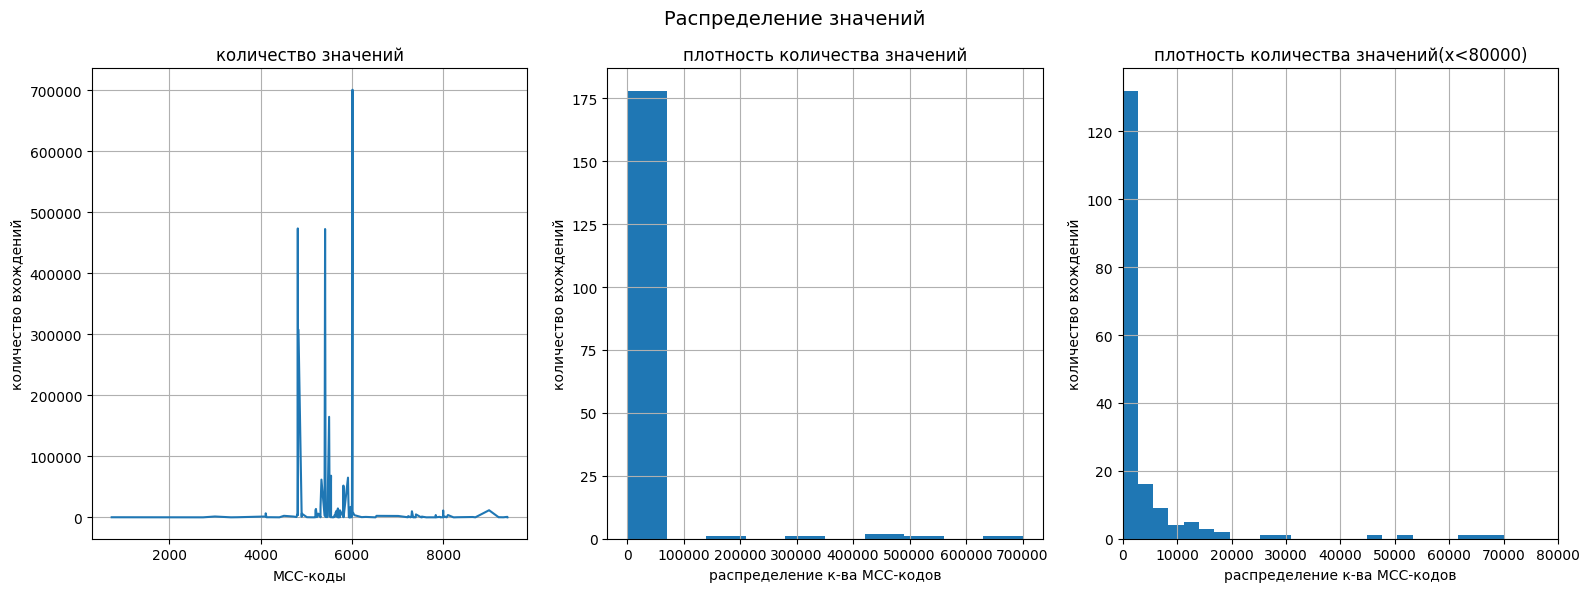

In [30]:
distr_values_diff_scale(df_train)

Можно сделать выводы:
1. Левый график демонстрирует распределение количества MCC-кодов выборке, он эквивалентен гистограмме, на нем изображен диапазон значений и пики наиболее часто встречающихся.
2. Средний график, это результат подсчёта количества MCC-кодов и частоты встречаемости такого количества значений в выборке. Он говорит о том, что есть набор MCC-кодов, которые специфичны для каких-то групп пользователей, а есть те, которые характерны для всех.
3. Справа изображён тот же график, что и в середине, только в другом масштабе.

Изучим, какой процент от набора данных составляют наиболее часто встречающиеся коды

In [31]:
def top10_distribution_MCC1(df):
    colours = {
        '6011':'C0', '6010':'C1', '4814':'C2', '5411':'C3',
        '4829':'C4', '5499':'C5', '5541':'C6', '5912':'C7',
        '5331':'C8', '5812':'C9'
    }

    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
    fig.suptitle('Распределение MCC-кодов' + '\n' + 'df_train', color='olive', fontsize=14)
    count = 0
    try:
        for el in df.columns:
            # make data
            some_info = df[el].explode().value_counts().head(10)
            some_info = (
                         round(some_info/some_info.sum()*100, 2)
                         .reset_index()
                         .rename(columns = {'Data':'lbl', 'Target':'lbl', 'count':'total'})
                         .sort_values(by='total', ascending=False)
                        )
            lbl = list(map(str, some_info['lbl']))
            var = list(map(int, some_info['total']))

            # plot
            ax[count].bar(lbl, var, color=[colours[key] for key in lbl], width=0.8)
            ax[count].set_xlabel('MCC-коды')
            ax[count].set_ylabel('% содержание в выборке')
            ax[count].set_title(el, color='m', fontsize=12)
            ax[count].grid()
            count += 1
            
    except Exception as err:
        print('Возникла ошибка:', err)
    fig.tight_layout()    

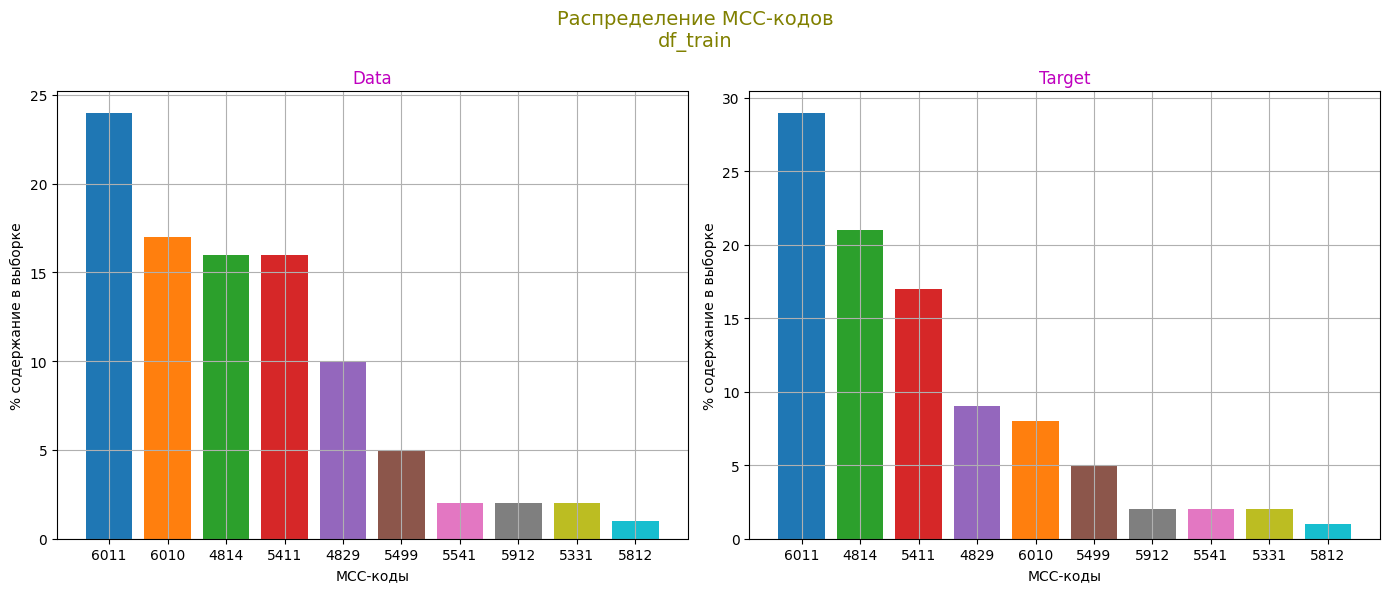

In [32]:
top10_distribution_MCC1(df_train)

*Данные сложно поддаются восприятию, поэтому для очеловечивания, представим небольшой разбор происходящего.* \
**Расшифровка** 
* 6011 — снятие наличных;
* 6010 — выдача наличных в кассе;
* 4814 — телекоммуникационные услуги;
* 5411 — бакалейные магазины, супермаркеты;
* 4829 — денежные переводы;
* 5499 — различные продовольственные магазины;
* 5541 — заправочные станции;
* 5912 — аптеки;
* 5331 — универсальные магазины;
* 5812 — места общественного питания, рестораны.

In [ ]:
print(df_train['Data'].explode().value_counts()[-10:])

In [ ]:
len(df_train['Data'].explode().unique())

In [ ]:
df_train['Data'].explode().hist(bins=50) # плотность значений

In [ ]:
# построение графика плотности значений выше в разных масштабах
def distr_values_diff_scale(df):
    """
    гистограмма распределения значений
    и гистограмма, распределения
    редких значений в выборке
    """
    # Подготовка данных
    base = df_train['Data'].explode().value_counts().reset_index()
    graph = base.sort_values(by='Data')
    # Подготовка графиков
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    fig.suptitle('Распределение значений', fontsize=14)
    count = 0
    # Словарь с функциями и подписями осей для удобства построения разных графиков
    x_min = 80000
    make_graph = {'количество значений':[lambda x: x.plot(graph['Data'], graph['count']),
                                         'МСС-коды',
                                         'количество вхождений',
                                          None, None
                                        ],
                  'плотность количества значений':[lambda x: x.hist(base['count']),
                                                   'распределение к-ва MCC-кодов',
                                                   'количество вхождений',
                                                    None, None
                                                  ],
                  f'плотность количества значений(x<{x_min})':[lambda x: x.hist(base['count'], bins=250),
                                                   'распределение к-ва MCC-кодов',
                                                   'количество вхождений',
                                                    0, x_min
                  ]
                 }
    # Построение графиков
    for key, value in make_graph.items():
        value[0](ax[count])
        ax[count].set_title(key)
        ax[count].set_xlabel(value[1])
        ax[count].set_ylabel(value[2])
        ax[count].set_xlim(xmin=value[3],xmax=value[4])
        ax[count].grid(True)
        count += 1

    fig.tight_layout()
    
distr_values_diff_scale(df_train)

In [ ]:
(
    df_train['Data'].explode()
.value_counts().reset_index().sort_values(by='Data')
.plot('Data', 'count', legend=False, grid=True) 
)

In [ ]:
df_train['Data'].explode().value_counts().reset_index()

In [ ]:
df_train['Data'].explode().value_counts().reset_index()

In [ ]:
for_fig = df_train['Data'].explode().value_counts().reset_index()
len_col = len(for_fig.columns)

fig, ax = plt.subplots(nrows=1, ncols=len_col, figsize=(10,4))
fig.suptitle('Характеристики MCC-кодов', fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9)
di = {'Data': ['Распределение МСС-кодов', 'Частота'], 'count':['К-во MCC-кодов', 'Распределение от параметра bins']}

count = 0
for key, value in di.items():
    ax[count].hist(for_fig[key], bins = 20)
    ax[count].grid()
    ax[count].set_xlabel(value[0])
    ax[count].set_ylabel(value[1])
    ax[count].tick_params('x', labelrotation = 0)
    #ax[count].xaxis.set_ticks(np.arange(fig1['year_of_release'][0], 2016.1, step))
    count += 1

fig.tight_layout();

Посмотрим на предсказания. Изучим какое значение в среднем бывет.

In [ ]:
len([int(el) for el in submission_baseline_2.loc[0, 'Predicted'][1:-1].split()])

In [ ]:
how = submission_baseline_2['Predicted'].apply(lambda x: len([int(el) for el in x[1: -1].split()]))
how.describe()

In [ ]:
how.hist(range=(11, 20))
plt.title('Количество предсказаний')
plt.xlabel('классы')
plt.ylabel('количество');

### Вывод

* для `df_train` и `df_test` можно сделать заключение, что необходимо преобразовать данные из строчного формата в целочисленный;
* MCC коды напоминают токены в обработке текста, возможно это свойство получиться использовать;
* также, вероятно, что данные подойдут для обучения нейросетью. 


Приведение значений из строчного формата в чиловой

In [ ]:
df_train.head(2)

In [ ]:
df_test.head(2)

In [ ]:
submission_baseline_2.head(2)

Изучим получившиеся наборы данных

In [ ]:
df_train.head()

Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.

In [ ]:
# d_train = {}
# for el in df_train.loc[0, 'Data']:
#     if el not in d_train.keys():
#         d_train[el] = 1
#     else:
#         d_train[el] += 1

# #d_train
# for key, val in d_train.items():
#     df_train.loc[:, key] = val
#     print(key, val)

In [ ]:
def make_columns(row):
    d_train = {}
    for el in row['Data']:
        if el not in d_train.keys():
            d_train[el] = 1
        else:
            d_train[el] += 1

    
    # display(pd.DataFrame([d_train.values()], columns=d_train.keys()))
    new_data = pd.DataFrame([d_train.values()], columns=d_train.keys())
    
    # for key, val in d_train.items():
    #     row[key] = val
    
    # print(key, val)
    # print(row)
    # # row[2] = d_train.keys()
    
    return row#d_train.keys()
    

    

In [ ]:
df_train.head(1).apply(make_columns, axis=1)

In [ ]:
df_train.head()

In [ ]:
for el in set(df_train.loc[0, 'Data']):
    print(df_train.loc[df_train['Data'] == el, 'Data'])

In [ ]:
[i for i in range(len(df_train.loc[0, 'Data'])) if df_train.loc[0, 'Data'][i] == 4814]

In [ ]:
df_train.loc[0, 'Data'][0]

Определим функцию для отображения первичной информации

In [ ]:
def first_info(name):
    display(name.head())
    display(name.info())

In [ ]:
top10_codes = df_train['Data'].explode().value_counts().head(10)
top10_codes

In [ ]:
df_train['Data'].explode().value_counts().reset_index().hist(bins=20)

In [ ]:
boxplot_train = df_train['Data'].explode().value_counts().reset_index().boxplot('Data', return_type='dict')
boxplot_train;

Получим граничные значения

In [ ]:
[item.get_ydata()[1] for item in boxplot_train['whiskers']] 

*Значения, которые не соответствуют диапазону удалим*

Общая концепция: 
1. Избавиться от выбросов
2. Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.
3. Обучить модель на данных
4. Предсказать значения для нескольких случаев(10)

In [ ]:
first_info(submission_baseline_2)

## fgfg

In [ ]:
def str_info(num):
    print(len(df_train.loc[num, 'Data']))
    print(len(df_test.loc[num, 'Data']))
    print(len(submission_baseline_2.loc[num, "Predicted"][1:-1].split(' ')))

str_info(0)

In [ ]:
# for i in range(5):
#     print(i+1)
#     str_info(i)
#     print()

In [ ]:
submission_baseline_2.columns